### Tentativa 1: Midas

Código provindo em partes do tutorial https://pytorch.org/hub/intelisl_midas_v2/

In [9]:
import cv2
import torch
import numpy as np
import time
import matplotlib.pyplot as plt

def load_models(model_type: str):
    midas = torch.hub.load("intel-isl/MiDaS", model_type)
    device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
    midas.to(device)
    midas.eval()

    midas_transforms = torch.hub.load("intel-isl/MiDaS", "transforms")

    if model_type == "DPT_Large" or model_type == "DPT_Hybrid":
        transform = midas_transforms.dpt_transform
    else:
        transform = midas_transforms.small_transform
    return midas, transform, device

def get_depth(midas, transform, device) -> np.ndarray:
    img = cv2.imread("placeholder_test.jpg")
    if img is None:
        raise ValueError("Image not found or unable to load. Check the file path.")

    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

    input_batch = transform(img).to(device)

    with torch.no_grad():
        start_time = time.time()
        prediction = midas(input_batch)
        end_time = time.time()
        print(f"Inference time: {end_time - start_time:.4f} seconds")


        prediction = torch.nn.functional.interpolate(
            prediction.unsqueeze(1),
            size=img.shape[:2],
            mode="bicubic",
            align_corners=False,
        ).squeeze()

    output = prediction.cpu().numpy()

    return output

def show_images(*images):
    n = len(images)
    plt.figure(figsize=(15, 5))
    for i in range(n):
        plt.subplot(1, n, i + 1)
        plt.imshow(images[i], cmap='viridis')
        plt.colorbar(label="Depth Value")
        plt.axis('off')
    plt.show()


In [ ]:
# RUN ONCE ONLY TO LOAD MODELS.
midas_s, transform_s, device = load_models("MiDaS_small")
midas_h, transform_h, device = load_models("DPT_Hybrid")

Using cache found in /home/admi/.cache/torch/hub/intel-isl_MiDaS_master
/home/admi/MC949_Visao_Computacional/venv_mc949/lib/python3.12/site-packages/timm/models/layers/__init__.py:48: FutureWarning: Importing from timm.models.layers is deprecated, please import via timm.layers
  warnings.warn(f"Importing from {__name__} is deprecated, please import via timm.layers", FutureWarning)


Loading weights:  None


Using cache found in /home/admi/.cache/torch/hub/rwightman_gen-efficientnet-pytorch_master
Using cache found in /home/admi/.cache/torch/hub/intel-isl_MiDaS_master
Using cache found in /home/admi/.cache/torch/hub/intel-isl_MiDaS_master
/home/admi/MC949_Visao_Computacional/venv_mc949/lib/python3.12/site-packages/timm/models/_factory.py:138: UserWarning: Mapping deprecated model name vit_base_resnet50_384 to current vit_base_r50_s16_384.orig_in21k_ft_in1k.
  model = create_fn(
Using cache found in /home/admi/.cache/torch/hub/intel-isl_MiDaS_master


Inference time: 0.0043 seconds
Inference time: 0.0096 seconds


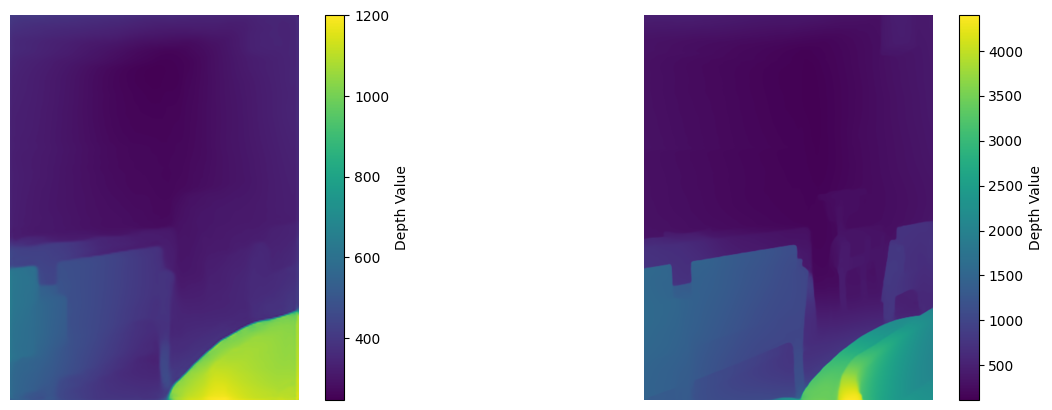

In [10]:
img1 = get_depth(midas_s, transform_s, device)  # MiDaS v2.1 - Small   (lowest accuracy, highest inference speed)
img2 = get_depth(midas_h, transform_h, device)  # MiDaS v3 - Hybrid    (medium accuracy, medium inference speed)

show_images(img1, img2)
